## Start by importing necessary packages
You will begin by importing necessary libraries for this notebook. Run the cell below to do so.

# PyTorch and Intro to Training

In [1]:
!pip install thop
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import thop
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


## Checking the torch version and CUDA access
Let's start off by checking the current torch version, and whether you have CUDA availablity.

In [2]:
print("torch is using version:", torch.__version__, "with CUDA=", torch.cuda.is_available())

torch is using version: 2.5.1+cu121 with CUDA= True


By default, you will see CUDA = False, meaning that the Colab session does not have access to a GPU. To remedy this, click the Runtime menu on top and select "Change Runtime Type", then select "T4 GPU".

Re-run the import cell above, and the CUDA version / check. It should show now CUDA = True

Sometimes in Colab you get a message that your Session has crashed, if that happens you need to go to the Runtime menu on top and select "Restart session".

You won't be using the GPU just yet, but this prepares the instance for when you will.

**Please note that the GPU is a scarce resource which may not be available at all time. Additionally, there are also usage limits that you may run into (although not likely for this assignment). When that happens you need to try again later/next day/different time of the day. Another reason to start the assignment early!**

## A Brief Introduction to PyTorch

PyTorch, or torch, is a machine learning framework developed my Facebook AI Research, which competes with TensorFlow, JAX, Caffe and others.

Roughly speaking, these frameworks can be split into dynamic and static defintion frameworks.

**Static Network Definition:** The architecture and computation flow are defined simultaneously. The order and manner in which data flows through the layers are fixed upon definition. These frameworks also tend to declare parameter shapes implicitly via the compute graph. This is typical of TensorFlow and JAX.

**Dynamic Network Definition:** The architecture (layers/modules) is defined independently of the computation flow, often during the object's initialization. This allows for dynamic computation graphs where the flow of data can change during runtime based on conditions. Since the network exists independent of the compute graph, the parameter shapes must be declared explitly. PyTorch follows this approach.

All ML frameworks support automatic differentiation, which is necessary to train a model (i.e. perform back propagation).

Let's consider a typical pytorch module. Such modules will inherit from the torch.nn.Module class, which provides many built in functions such as a wrapper for `__call__`, operations to move the module between devices (e.g. `cuda()`, `cpu()`), data-type conversion (e.g. `half()`, `float()`), and parameter and child management (e.g. `state_dict()`, `parameters()`).

In [3]:
# inherit from torch.nn.Module
class MyModule(nn.Module):
  # constructor called upon creation
  def __init__(self):
    # the module has to initialize the parent first, which is what sets up the wrapper behavior
    super().__init__()

    # we can add sub-modules and parameters by assigning them to self
    self.my_param = nn.Parameter(torch.zeros(4,8)) # this is how you define a raw parameter of shape 4x5
    self.my_sub_module = nn.Linear(8,12)       # this is how you define a linear layer (tensorflow calls them Dense) of shape 8x12

    # we can also add lists of modules, for example, the sequential layer
    self.net = nn.Sequential(  # this layer type takes in a collection of modules rather than a list
        nn.Linear(4,4),
        nn.Linear(4,8),
        nn.Linear(8,12)
    )

    # the above when calling self.net(x), will execute each module in the order they appear in a list
    # it would be equivelent to x = self.net[2](self.net[1](self.net[0](x)))

    # you can also create a list that doesn't execute
    self.net_list = nn.ModuleList([
        nn.Linear(7,7),
        nn.Linear(7,9),
        nn.Linear(9,14)
    ])

    # sometimes you will also see constant variables added to the module post init
    foo = torch.Tensor([4])
    self.register_buffer('foo', foo) # buffers allow .to(device, type) to apply

  # let's define a forward function, which gets executed when calling the module, and defines the forward compute graph
  def forward(self, x):

    # if x is of shape Bx4
    h1 =  x @ self.my_param # tensor-tensor multiplication uses the @ symbol
    # then h1 is now shape Bx8, because my_param is 4x8... 2x4 * 4x8 = 2x8

    h1 = self.my_sub_module(h1) # you execute a sub-module by calling it
    # now, h1 is of shape Bx12, because my_sub_module was a 8x12 matrix

    h2 = self.net(x)
    # similarly, h2 is of shape Bx12, because that's the output of the sequence
    # Bx4 -(4x4)-> Bx4 -(4x8)-> Bx8 -(8x12)-> Bx12

    # since h1 and h2 are the same shape, they can be added together element-wise
    return h1 + h2


Then you can instantiate the module and perform a forward pass by calling it.

In [4]:
# create the module
module = MyModule()

# you can print the module to get a high-level summary of it
print("=== printing the module ===")
print(module)
print()
# notice that the sub-module name is in parenthesis, and so are the list indicies

# let's view the shape of one of the weight tensors
print("my_sub_module weight tensor shape=", module.my_sub_module.weight.shape)
# the above works because nn.Linear has a member called .weight and .bias
# to view the shape of my_param, you would use module.my_param
# and to view the shape of the 2nd elment in net_list, you would use module.net_list[1].weight

# you can iterate through all of the parameters via the state dict
print()
print("=== Listing parameters from the state_dict ===")
for key,value in module.state_dict().items():
  print(f"{key}: {value.shape}")


=== printing the module ===
MyModule(
  (my_sub_module): Linear(in_features=8, out_features=12, bias=True)
  (net): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=12, bias=True)
  )
  (net_list): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=14, bias=True)
  )
)

my_sub_module weight tensor shape= torch.Size([12, 8])

=== Listing parameters from the state_dict ===
my_param: torch.Size([4, 8])
foo: torch.Size([1])
my_sub_module.weight: torch.Size([12, 8])
my_sub_module.bias: torch.Size([12])
net.0.weight: torch.Size([4, 4])
net.0.bias: torch.Size([4])
net.1.weight: torch.Size([8, 4])
net.1.bias: torch.Size([8])
net.2.weight: torch.Size([12, 8])
net.2.bias: torch.Size([12])
net_list.0.weight: torch.Size([7, 7])
net_list.0.bias: torch.Size([7

In [5]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
y = module(x)

# then you can print the result and shape
print(y, y.shape)

tensor([[ 0.6243, -0.4465,  0.4141, -0.2607, -0.0356,  0.1575,  0.5412, -0.0406,
         -0.0718,  0.1926,  0.0731, -0.2583],
        [ 0.6243, -0.4465,  0.4141, -0.2607, -0.0356,  0.1575,  0.5412, -0.0406,
         -0.0718,  0.1926,  0.0731, -0.2583]], grad_fn=<AddBackward0>) torch.Size([2, 12])


Please check the cell below to notice the following:

1.   `x` above was created with the shape 2x4, and in the forward pass, it gets manipulated into a 2x12 tensor. This last dimension is explicit, while the first is called the batch dimmension, and only exists on data (a.k.a. activations). The output shape can be seen in the print statement from y.shape
2.   You can view the shape of a tensor by using `.shape`, this is a very helpful trick for debugging tensor shape errors
3.   In the output, there's a `grad_fn` component, this is the hook created by the forward trace to be used in back-propagation via automatic differentiation. The function name is `AddBackward`, because the last operation performed was `h1+h2`.

We might not always want to trace the compute graph though, such as during inference. In such cases, you can use the `torch.no_grad()` context manager.


In [6]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
with torch.no_grad():
  y = module(x)

# then you can print the result and shape
print(y, y.shape)
# notice how the grad_fn is no longer part of the output tensor, that's because not_grad() disables the graph generation

tensor([[ 0.6243, -0.4465,  0.4141, -0.2607, -0.0356,  0.1575,  0.5412, -0.0406,
         -0.0718,  0.1926,  0.0731, -0.2583],
        [ 0.6243, -0.4465,  0.4141, -0.2607, -0.0356,  0.1575,  0.5412, -0.0406,
         -0.0718,  0.1926,  0.0731, -0.2583]]) torch.Size([2, 12])


Aside from passing a tensor through a model with the `no_grad()` context, you can also detach a tensor from the compute graph by calling `.detach()`. This will effectively make a copy of the original tensor, which allows it to be converted to numpy and visualized with matplotlib.

**Note:** Tensors with a `grad_fn` property cannot be plotted and must first be detached.

## Multi-Layer-Perceptron (MLP) Prediction of MNIST

With some basics out of the way, let's create a MLP for training MNIST.
You can start by defining a simple torch model.

In [7]:
# Define the MLP model
class MLP(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # the input projection layer - projects into d=128
        self.fc1 = nn.Linear(28*28, 128)
        # the first hidden layer - compresses into d=64
        self.fc2 = nn.Linear(128, 64)
        # the final output layer - splits into 10 classes (digits 0-9)
        self.fc3 = nn.Linear(64, 10)

    # define the forward pass compute graph
    def forward(self, x):
        # x is of shape BxHxW

        # we first need to unroll the 2D image using view
        # we set the first dim to be -1 meanining "everything else", the reason being that x is of shape BxHxW, where B is the batch dim
        # we want to maintain different tensors for each training sample in the batch, which means the output should be of shape BxF where F is the feature dim
        x = x.view(-1, 28*28)
        # x is of shape Bx784

        # project-in and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc1(x))
        # x is of shape Bx128

        # middle-layer and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc2(x))
        # x is of shape Bx64

        # project out into the 10 classes
        x = self.fc3(x)
        # x is of shape Bx10
        return x

Before you can begin training, you have to do a little boiler-plate to load the dataset. From the previous assignment, you saw how a hosted dataset can be loaded with TensorFlow. With pytorch it's a little more complicated, as you need to manually condition the input data.

In [8]:
# define a transformation for the input images. This uses torchvision.transforms, and .Compose will act similarly to nn.Sequential
transform = transforms.Compose([
    transforms.ToTensor(), # first convert to a torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # then normalize the input
])

# let's download the train and test datasets, applying the above transform - this will get saved locally into ./data, which is in the Colab instance
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# we need to set the mini-batch (commonly referred to as "batch"), for now we can use 64
batch_size = 64

# then we need to create a dataloader for the train dataset, and we will also create one for the test dataset to evaluate performance
# additionally, we will set the batch size in the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# the torch dataloaders allow us to access the __getitem__ method, which returns a tuple of (data, label)
# additionally, the dataloader will pre-colate the training samples into the given batch_size


Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.68MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Inspect the first element of the test_loader, and verify both the tensor shapes and data types. You can check the data-type with `.dtype`

**Question 1**

Edit the cell below to print out the first element shapes, dtype, and identify which is the training sample and which is the training label.

In [9]:
# Get the first item
first_item = next(iter(test_loader))
first =first_item[0]
second = first_item[1]


print("Training Sample (features):")
print(f"Shape: {first.shape}")
print(f"Dtype: {first.dtype}")

print("\nTraining Label (target):")
print(f"Shape: {second.shape}")
print(f"Dtype: {second.dtype}")

# print out the element shapes, dtype, and identify which is the training sample and which is the training label
# MNIST is a supervised learning task

Training Sample (features):
Shape: torch.Size([64, 1, 28, 28])
Dtype: torch.float32

Training Label (target):
Shape: torch.Size([64])
Dtype: torch.int64


Now that we have the dataset loaded, we can instantiate the MLP model, the loss (or criterion function), and the optimizer for training.

In [10]:
# create the model
model = MLP()

# you can print the model as well, but notice how the activation functions are missing. This is because they were called in the forward pass
# and not declared in the constructor
print(model)

# you can also count the model parameters
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# for a critereon (loss) function, you will use Cross-Entropy Loss. This is the most common criterion used for multi-class prediction,
# and is also used by tokenized transformer models it takes in an un-normalized probability distribution (i.e. without softmax) over
# N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label which is < N.
# For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum
# factor of 0.5. the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model has 109,386 trainable parameters


Finally, you can define a training, and test loop

In [11]:
# create an array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [12]:
# declare the train function
def cpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as
    # batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the
    # iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # then you can apply a forward pass, which includes evaluating the loss (criterion)
        output = model(data)
        loss = criterion(output, target)

        # given that you want to minimize the loss, you need to call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all you have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # you should add some output to the progress bar so that you know which epoch you are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help you evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def cpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for you, but it is needed with other layers like batch_norm
    # and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since you are not training the model, and do not need back-propagation, you can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # like with training, run a forward pass through the model and evaluate the criterion
            output = model(data)
            test_loss += criterion(output, target).item() # you are using .item() to get the loss value rather than the tensor itself

            # you can also check the accuracy by sampling the output - you can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [13]:
# train for 10 epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.259051: 100%|██████████| 938/938 [00:13<00:00, 71.96it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.58it/s]



Test set: Average loss: 0.2674, Accuracy: 9190/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.217266: 100%|██████████| 938/938 [00:13<00:00, 70.55it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.86it/s]



Test set: Average loss: 0.1965, Accuracy: 9401/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.116211: 100%|██████████| 938/938 [00:12<00:00, 74.41it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 83.25it/s]



Test set: Average loss: 0.1599, Accuracy: 9525/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.087400: 100%|██████████| 938/938 [00:12<00:00, 73.59it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 64.78it/s]



Test set: Average loss: 0.1325, Accuracy: 9602/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.139793: 100%|██████████| 938/938 [00:12<00:00, 73.46it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 84.69it/s]



Test set: Average loss: 0.1182, Accuracy: 9633/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.073825: 100%|██████████| 938/938 [00:12<00:00, 72.84it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 84.37it/s]



Test set: Average loss: 0.1016, Accuracy: 9692/10000 (97%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.094368: 100%|██████████| 938/938 [00:12<00:00, 73.71it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.65it/s]



Test set: Average loss: 0.0918, Accuracy: 9723/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.050134: 100%|██████████| 938/938 [00:12<00:00, 74.24it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 84.97it/s]



Test set: Average loss: 0.0864, Accuracy: 9727/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.128949: 100%|██████████| 938/938 [00:12<00:00, 72.37it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 61.21it/s]



Test set: Average loss: 0.0812, Accuracy: 9754/10000 (98%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.043976: 100%|██████████| 938/938 [00:12<00:00, 73.75it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 83.69it/s]


Test set: Average loss: 0.0795, Accuracy: 9761/10000 (98%)



**Question 2**

Using the skills you acquired in the previous assignment edit the cell below to use matplotlib to visualize the loss for training and validation for the first 10 epochs. They should be plotted on the same graph, labeled, and use a log-scale on the y-axis.

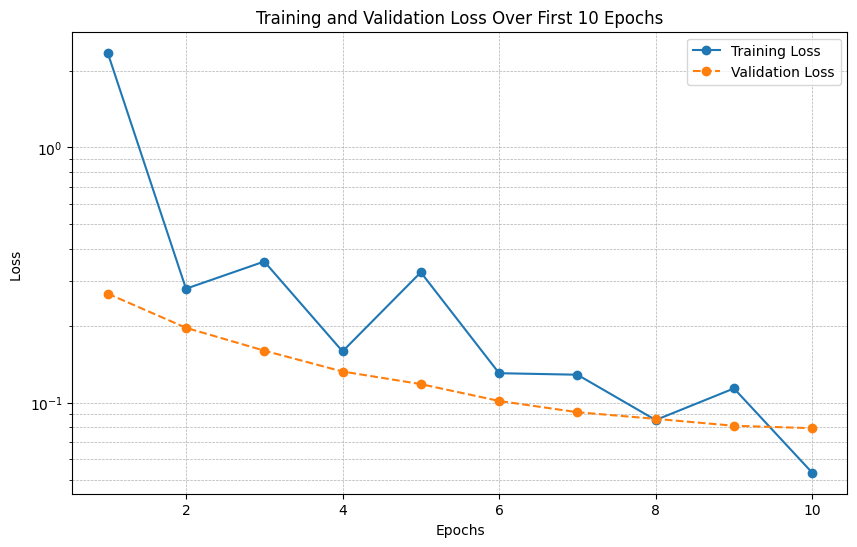

In [14]:
import matplotlib.pyplot as plt

# Extract the first 10 epochs of loss data
epochs = list(range(1, 11))  # Epoch numbers 1 to 10
train_loss_subset = train_losses[::10]
test_loss_subset = test_losses[:10]

# Plotting
plt.figure(figsize=(10, 6))

# Plot training and validation losses
plt.plot(epochs, train_loss_subset, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, test_losses, label='Validation Loss', marker='o', linestyle='--')

# # Set log-scale for the y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss ')
plt.title('Training and Validation Loss Over First 10 Epochs')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


**Question 3**

The model may be able to train for a bit longer. Edit the cell below to modify the previous training code to also report the time per epoch and the time for 10 epochs with testing. You can use `time.time()` to get the current time in seconds.
Then run the model for another 10 epochs, printing out the execution time at the end, and replot the loss functions with the extra 10 epochs below.

In [15]:
train_losses = []
train_steps = []
test_losses = []
test_accuracy = []
current_step = 0
epoch_times = []

In [16]:
model.cpu()

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
# visualize the losses for 20 epochs

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Declare the train function with time tracking
def cpu_train(epoch, train_losses, steps, current_step):
    start_time = time.time()  # Start time for the current epoch

    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, target) in pbar:
        optimizer.zero_grad()  # Reset gradients

        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Apply gradients to update weights

        current_step += 1

        if batch_idx % 100 == 0:
            train_losses.append(loss.item())
            steps.append(current_step)
            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    end_time = time.time()  # End time for the current epoch
    epoch_time = end_time - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    return current_step, epoch_time

# Declare the test function with time tracking
def cpu_test(test_losses, test_accuracy, steps, current_step):
    model.eval()
    test_loss = 0
    correct = 0

    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    with torch.no_grad():
        for data, target in pbar:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    test_losses.append(test_loss)
    test_accuracy.append(correct / len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Training for 20 epochs (additional 10 epochs after the first 10)
# To store the time for each epoch

# First 10 epochs (Already existing code)
for epoch in range(10):
    current_step, epoch_time = cpu_train(epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    epoch_times.append(epoch_time)
    print(f"Total time after epoch {epoch + 1}: {sum(epoch_times):.2f} seconds")

# Additional 10 epochs (with time tracking and testing)
for epoch in range(10, 20):  # Run for 10 more epochs
    current_step, epoch_time = cpu_train(epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    epoch_times.append(epoch_time)  # Store the epoch time
    print(f"Total time after epoch {epoch + 1}: {sum(epoch_times):.2f} seconds")


# Print the total time for 20 epochs (including testing)
total_time = sum(epoch_times)
print(f"Total time for 20 epochs (including testing): {total_time:.2f} seconds")


Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.066432: 100%|██████████| 938/938 [00:12<00:00, 74.00it/s]


Epoch 0 completed in 12.68 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 84.72it/s]



Test set: Average loss: 0.0750, Accuracy: 9771/10000 (98%)

Total time after epoch 1: 12.68 seconds


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.037564: 100%|██████████| 938/938 [00:12<00:00, 72.54it/s]


Epoch 1 completed in 12.94 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.88it/s]



Test set: Average loss: 0.0738, Accuracy: 9764/10000 (98%)

Total time after epoch 2: 25.62 seconds


Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.024213: 100%|██████████| 938/938 [00:13<00:00, 72.04it/s]


Epoch 2 completed in 13.03 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.43it/s]



Test set: Average loss: 0.0706, Accuracy: 9769/10000 (98%)

Total time after epoch 3: 38.65 seconds


Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.020615: 100%|██████████| 938/938 [00:12<00:00, 72.39it/s]


Epoch 3 completed in 12.97 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.15it/s]



Test set: Average loss: 0.0737, Accuracy: 9766/10000 (98%)

Total time after epoch 4: 51.61 seconds


Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.041277: 100%|██████████| 938/938 [00:12<00:00, 74.61it/s]


Epoch 4 completed in 12.58 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 87.45it/s]



Test set: Average loss: 0.0684, Accuracy: 9785/10000 (98%)

Total time after epoch 5: 64.19 seconds


Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.075109: 100%|██████████| 938/938 [00:12<00:00, 74.24it/s]


Epoch 5 completed in 12.64 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.06it/s]



Test set: Average loss: 0.0673, Accuracy: 9782/10000 (98%)

Total time after epoch 6: 76.83 seconds


Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.047962: 100%|██████████| 938/938 [00:12<00:00, 74.82it/s]


Epoch 6 completed in 12.54 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.12it/s]



Test set: Average loss: 0.0682, Accuracy: 9771/10000 (98%)

Total time after epoch 7: 89.38 seconds


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.061206: 100%|██████████| 938/938 [00:12<00:00, 74.55it/s]


Epoch 7 completed in 12.59 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 60.85it/s]



Test set: Average loss: 0.0651, Accuracy: 9788/10000 (98%)

Total time after epoch 8: 101.97 seconds


Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.039698: 100%|██████████| 938/938 [00:12<00:00, 74.26it/s]


Epoch 8 completed in 12.64 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 87.09it/s]



Test set: Average loss: 0.0651, Accuracy: 9784/10000 (98%)

Total time after epoch 9: 114.61 seconds


Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.029798: 100%|██████████| 938/938 [00:12<00:00, 75.08it/s]


Epoch 9 completed in 12.50 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.39it/s]



Test set: Average loss: 0.0656, Accuracy: 9792/10000 (98%)

Total time after epoch 10: 127.11 seconds


Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.017514: 100%|██████████| 938/938 [00:12<00:00, 73.89it/s]


Epoch 10 completed in 12.70 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.61it/s]



Test set: Average loss: 0.0658, Accuracy: 9796/10000 (98%)

Total time after epoch 11: 139.81 seconds


Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.018463: 100%|██████████| 938/938 [00:12<00:00, 75.10it/s]


Epoch 11 completed in 12.50 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.91it/s]



Test set: Average loss: 0.0637, Accuracy: 9801/10000 (98%)

Total time after epoch 12: 152.30 seconds


Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.004443: 100%|██████████| 938/938 [00:12<00:00, 75.44it/s]


Epoch 12 completed in 12.44 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 80.80it/s]



Test set: Average loss: 0.0662, Accuracy: 9787/10000 (98%)

Total time after epoch 13: 164.74 seconds


Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.005412: 100%|██████████| 938/938 [00:12<00:00, 73.56it/s]


Epoch 13 completed in 12.76 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 68.10it/s]



Test set: Average loss: 0.0654, Accuracy: 9799/10000 (98%)

Total time after epoch 14: 177.50 seconds


Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.007985: 100%|██████████| 938/938 [00:12<00:00, 73.99it/s]


Epoch 14 completed in 12.69 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 83.77it/s]



Test set: Average loss: 0.0641, Accuracy: 9799/10000 (98%)

Total time after epoch 15: 190.19 seconds


Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.004524: 100%|██████████| 938/938 [00:12<00:00, 74.24it/s]


Epoch 15 completed in 12.64 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.43it/s]



Test set: Average loss: 0.0655, Accuracy: 9790/10000 (98%)

Total time after epoch 16: 202.83 seconds


Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.006419: 100%|██████████| 938/938 [00:12<00:00, 74.01it/s]


Epoch 16 completed in 12.68 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 84.71it/s]



Test set: Average loss: 0.0655, Accuracy: 9796/10000 (98%)

Total time after epoch 17: 215.51 seconds


Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.013407: 100%|██████████| 938/938 [00:12<00:00, 74.74it/s]


Epoch 17 completed in 12.56 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.05it/s]



Test set: Average loss: 0.0647, Accuracy: 9803/10000 (98%)

Total time after epoch 18: 228.07 seconds


Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.006510: 100%|██████████| 938/938 [00:12<00:00, 74.74it/s]


Epoch 18 completed in 12.56 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 70.06it/s]



Test set: Average loss: 0.0655, Accuracy: 9803/10000 (98%)

Total time after epoch 19: 240.63 seconds


Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.009089: 100%|██████████| 938/938 [00:12<00:00, 73.20it/s]


Epoch 19 completed in 12.82 seconds


Testing...: 100%|██████████| 157/157 [00:01<00:00, 79.38it/s]


Test set: Average loss: 0.0677, Accuracy: 9789/10000 (98%)

Total time after epoch 20: 253.46 seconds
Total time for 20 epochs (including testing): 253.46 seconds


In [18]:
len(train_losses)

200

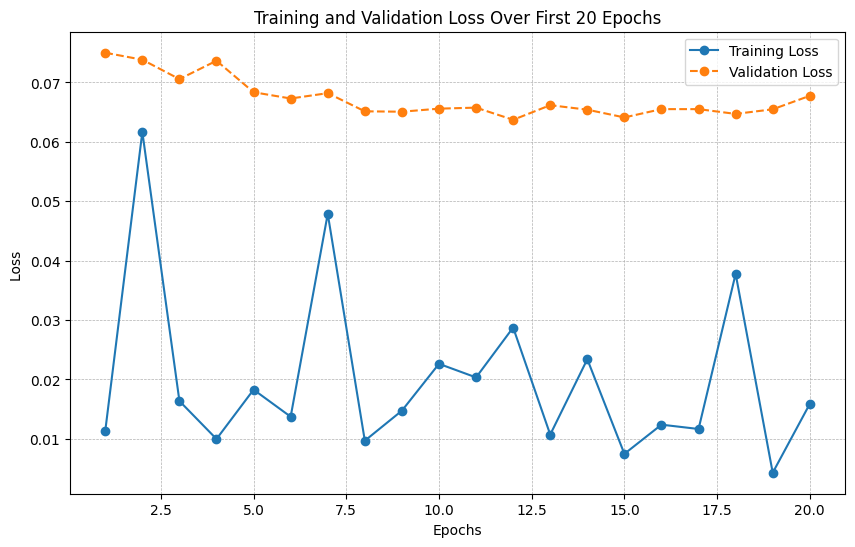

In [19]:
import matplotlib.pyplot as plt

# Extract the first 10 epochs of loss data
epochs = list(range(1, 21))
train_loss_subset = train_losses[::10]

# Plotting
plt.figure(figsize=(10, 6))

# Plot training and validation losses
plt.plot(epochs, train_loss_subset, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, test_losses, label='Validation Loss', marker='o', linestyle='--')

# # # Set log-scale for the y-axis
# plt.yscale('log')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss ')
plt.title('Training and Validation Loss Over First 20 Epochs')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


**Question 4**

Make an observation from the above plot. Do the test and train loss curves indicate that the model should train longer to improve accuracy? Or does it indicate that 20 epochs is too long? Edit the cell below to answer these questions.

#Answer 4
The plot shows the training and validation loss over the first 20 epochs. Based on the trends:

1. Observation:

* The training and validation loss decrease sharply in the first few epochs and then stabilize after around 5 epochs.
* Beyond this point, both curves are almost flat, suggesting that the model has converged, and additional training does not significantly improve performance.
2. Does the model need more training?
No, the curves do not indicate that additional training beyond 20 epochs would improve accuracy, as both losses are already low and stable.

3. Are 20 epochs too long?
Yes, it seems 20 epochs might be unnecessary. The model stabilizes by around 5 epochs, so stopping early using techniques like early stopping could save time and resources.

## Moving to the GPU

Now that you have a model trained on the CPU, let's finally utilize the T4 GPU that we requested for this instance.

Using a GPU with torch is relatively simple, but has a few gotchas. Torch abstracts away most of the CUDA runtime API, but has a few hold-over concepts such as moving data between devices.
Additionally, since the GPU is treated as a device separate from the CPU, you cannot combine CPU and GPU based tensors in the same operation. Doing so will result in a device mismatch error. If this occurs, check where the tensors are located (you can always print `.device` on a tensor), and make sure they have been properly moved to the correct device.

You will start by creating a new model, optimizer, and criterion (not really necessary in this case since you already did this above but it's better for clarity and completeness). However, one change that you'll make is moving the model to the GPU first. This can be done by calling `.cuda()` in general, or `.to("cuda")` to be more explicit. In general specific GPU devices can be targetted such as `.to("cuda:0")` for the first GPU (index 0), etc., but since there is only one GPU in Colab this is not necessary in this case.

In [20]:
# create the model
model = MLP()

# move the model to the GPU
model.cuda()

# for a critereon (loss) funciton, we will use Cross-Entropy Loss. This is the most common critereon used for multi-class prediction, and is also used by tokenized transformer models
# it takes in an un-normalized probability distribution (i.e. without softmax) over N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label
# which is < N. For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between what the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [21]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

Now, copy your previous training code with the timing parameters below.
It needs to be slightly modified to move everything to the GPU.

Before the line `output = model(data)`, add:
```
data = data.cuda()
target = target.cuda()
```

Note that this is needed in both the train and test functions.

**Question 5**

Please edit the cell below to show the new GPU train and test fucntions.

In [22]:
# the new GPU training functions
# declare the train function
def cpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as
    # batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the
    # iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # then you can apply a forward pass, which includes evaluating the loss (criterion)
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)

        # given that you want to minimize the loss, you need to call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all you have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # you should add some output to the progress bar so that you know which epoch you are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help you evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def cpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for you, but it is needed with other layers like batch_norm
    # and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since you are not training the model, and do not need back-propagation, you can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # like with training, run a forward pass through the model and evaluate the criterion
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item() # you are using .item() to get the loss value rather than the tensor itself

            # you can also check the accuracy by sampling the output - you can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [23]:
# train for 10 epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.130973: 100%|██████████| 938/938 [00:12<00:00, 72.98it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 78.53it/s]



Test set: Average loss: 0.2723, Accuracy: 9206/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.135196: 100%|██████████| 938/938 [00:12<00:00, 75.04it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 87.04it/s]



Test set: Average loss: 0.2030, Accuracy: 9399/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.127616: 100%|██████████| 938/938 [00:12<00:00, 75.65it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 79.32it/s]



Test set: Average loss: 0.1691, Accuracy: 9493/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.232791: 100%|██████████| 938/938 [00:12<00:00, 74.08it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 66.22it/s]



Test set: Average loss: 0.1385, Accuracy: 9590/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.108235: 100%|██████████| 938/938 [00:12<00:00, 75.30it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.53it/s]



Test set: Average loss: 0.1222, Accuracy: 9638/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.164607: 100%|██████████| 938/938 [00:12<00:00, 74.53it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 87.60it/s]



Test set: Average loss: 0.1109, Accuracy: 9663/10000 (97%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.050127: 100%|██████████| 938/938 [00:12<00:00, 75.79it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 85.60it/s]



Test set: Average loss: 0.1020, Accuracy: 9693/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.033185: 100%|██████████| 938/938 [00:12<00:00, 76.13it/s]
Testing...: 100%|██████████| 157/157 [00:01<00:00, 86.99it/s]



Test set: Average loss: 0.0943, Accuracy: 9719/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.058432: 100%|██████████| 938/938 [00:12<00:00, 75.08it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.37it/s]



Test set: Average loss: 0.0855, Accuracy: 9732/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.142726: 100%|██████████| 938/938 [00:12<00:00, 74.23it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 69.07it/s]


Test set: Average loss: 0.0825, Accuracy: 9736/10000 (97%)



**Question 6**

Is training faster now that it is on a GPU? Is the speedup what you would expect? Why or why not? Edit the cell below to answer.

#Answer 6
Yes, training on the GPU is faster, but the speedup might not be huge for smaller datasets like MNIST or simpler models like an MLP. This is because the workload is too small to fully use the GPU's power. For larger datasets or more complex models, the GPU would show much better speedup.

## Another Model Type: CNN

Until now you have trained a simple MLP for MNIST classification, however, MLPs are not a particularly good for images.

Firstly, using a MLP will require that all images have the same size and shape, since they are unrolled in the input.

Secondly, in general images can make use of translation invariance (a type of data symmetry), but this cannot but leveraged with a MLP.

For these reasons, a convolutional network is more appropriate, as it will pass kernels over the 2D image, removing the requirement for a fixed image size and leveraging the translation invariance of the 2D images.

Let's define a simple CNN below.

In [24]:
# Define the CNN model
class CNN(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # instead of declaring the layers independently, let's use the nn.Sequential feature
        # these blocks will be executed in list order

        # you will break up the model into two parts:
        # 1) the convolutional network
        # 2) the prediction head (a small MLP)

        # the convolutional network
        self.net = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # the input projection layer - note that a stride of 1 means you are not down-sampling
          nn.ReLU(),                                             # activation
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # an inner layer - note that a stride of 2 means you are down sampling. The output is 28x28 -> 14x14
          nn.ReLU(),                                             # activation
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# an inner layer - note that a stride of 2 means you are down sampling. The output is 14x14 -> 7x7
          nn.ReLU(),                                             # activation
          nn.AdaptiveMaxPool2d(1),                               # a pooling layer which will output a 1x1 vector for the prediciton head
        )

        # the prediction head
        self.head = nn.Sequential(
          nn.Linear(128, 64),      # input projection, the output from the pool layer is a 128 element vector
          nn.ReLU(),               # activation
          nn.Linear(64, 10)        # class projection to one of the 10 classes (digits 0-9)
        )


    # define the forward pass compute graph
    def forward(self, x):

        # pass the input through the convolution network
        x = self.net(x)

        # reshape the output from Bx128x1x1 to Bx128
        x = x.view(x.size(0), -1)

        # pass the pooled vector into the prediction head
        x = self.head(x)

        # the output here is Bx10
        return x

In [25]:
# create the model
model = CNN()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then you can intantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a
# momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


**Question 7**

Notice that this model now has fewer parameters than the MLP. Let's see how it trains.

Using the previous code to train on the CPU with timing, edit the cell below to execute 2 epochs of training.

In [26]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [27]:
model.cpu()

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [28]:
# train for 2 epochs on the CPU
# visualize the losses for 20 epochs

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Declare the train function with time tracking
def cpu_train(epoch, train_losses, steps, current_step):
    start_time = time.time()  # Start time for the current epoch

    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, target) in pbar:
        optimizer.zero_grad()  # Reset gradients

        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Apply gradients to update weights

        current_step += 1

        if batch_idx % 100 == 0:
            train_losses.append(loss.item())
            steps.append(current_step)
            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    end_time = time.time()  # End time for the current epoch
    epoch_time = end_time - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    return current_step, epoch_time

# Declare the test function with time tracking
def cpu_test(test_losses, test_accuracy, steps, current_step):
    model.eval()
    test_loss = 0
    correct = 0

    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    with torch.no_grad():
        for data, target in pbar:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    test_losses.append(test_loss)
    test_accuracy.append(correct / len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Training for 20 epochs (additional 10 epochs after the first 10)
# To store the time for each epoch

# First 10 epochs (Already existing code)
epoch_times=[]
for epoch in range(2):
    current_step, epoch_time = cpu_train(epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    epoch_times.append(epoch_time)
    print(f"Total time after epoch {epoch + 1}: {sum(epoch_times):.2f} seconds")

# # Additional 10 epochs (with time tracking and testing)
# for epoch in range(10, 20):  # Run for 10 more epochs
#     current_step, epoch_time = cpu_train(epoch, train_losses, train_steps, current_step)
#     cpu_test(test_losses, test_accuracy, test_steps, current_step)
#     epoch_times.append(epoch_time)  # Store the epoch time
#     print(f"Total time after epoch {epoch + 1}: {sum(epoch_times):.2f} seconds")


# Print the total time for 20 epochs (including testing)
total_time=0
total_time = sum(epoch_times)
print(f"Total time for 2 epochs (including testing): {total_time:.2f} seconds")


Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.571228: 100%|██████████| 938/938 [01:30<00:00, 10.31it/s]


Epoch 0 completed in 90.95 seconds


Testing...: 100%|██████████| 157/157 [00:04<00:00, 31.73it/s]



Test set: Average loss: 0.5801, Accuracy: 8200/10000 (82%)

Total time after epoch 1: 90.95 seconds


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.151537: 100%|██████████| 938/938 [01:35<00:00,  9.81it/s]


Epoch 1 completed in 95.63 seconds


Testing...: 100%|██████████| 157/157 [00:07<00:00, 22.25it/s]


Test set: Average loss: 0.2710, Accuracy: 9125/10000 (91%)

Total time after epoch 2: 186.58 seconds
Total time for 2 epochs (including testing): 186.58 seconds


**Question 8**

Now, let's move the model to the GPU and try training for 2 epochs there.

In [29]:
# create the model
model = CNN()

model.cuda()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


In [30]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [31]:
# train for 2 epochs on the GPU


# train for 2 epochs on the CPU
# visualize the losses for 20 epochs

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Declare the train function with time tracking
def cpu_train(epoch, train_losses, steps, current_step):
    start_time = time.time()  # Start time for the current epoch

    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, target) in pbar:
        optimizer.zero_grad()  # Reset gradients
        data = data.cuda()
        target = target.cuda()
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Apply gradients to update weights

        current_step += 1

        if batch_idx % 100 == 0:
            train_losses.append(loss.item())
            steps.append(current_step)
            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    end_time = time.time()  # End time for the current epoch
    epoch_time = end_time - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    return current_step, epoch_time

# Declare the test function with time tracking
def cpu_test(test_losses, test_accuracy, steps, current_step):
    model.eval()
    test_loss = 0
    correct = 0

    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    with torch.no_grad():
        for data, target in pbar:
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    test_losses.append(test_loss)
    test_accuracy.append(correct / len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Training for 20 epochs (additional 10 epochs after the first 10)
# To store the time for each epoch

epoch_times=[]
# First 10 epochs (Already existing code)
for epoch in range(2):
    current_step, epoch_time = cpu_train(epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    epoch_times.append(epoch_time)
    print(f"Total time after epoch {epoch + 1}: {sum(epoch_times):.2f} seconds")

# # Additional 10 epochs (with time tracking and testing)
# for epoch in range(10, 20):  # Run for 10 more epochs
#     current_step, epoch_time = cpu_train(epoch, train_losses, train_steps, current_step)
#     cpu_test(test_losses, test_accuracy, test_steps, current_step)
#     epoch_times.append(epoch_time)  # Store the epoch time
#     print(f"Total time after epoch {epoch + 1}: {sum(epoch_times):.2f} seconds")


# Print the total time for 20 epochs (including testing)
total_time=0
total_time = sum(epoch_times)
print(f"Total time for 2 epochs (including testing): {total_time:.2f} seconds")


Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.575949: 100%|██████████| 938/938 [00:14<00:00, 65.85it/s]


Epoch 0 completed in 14.25 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.06it/s]



Test set: Average loss: 0.4262, Accuracy: 8645/10000 (86%)

Total time after epoch 1: 14.25 seconds


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.303166: 100%|██████████| 938/938 [00:13<00:00, 68.98it/s]


Epoch 1 completed in 13.61 seconds


Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.82it/s]


Test set: Average loss: 0.2866, Accuracy: 9041/10000 (90%)

Total time after epoch 2: 27.85 seconds
Total time for 2 epochs (including testing): 27.85 seconds


**Question 9**

How do the CPU and GPU versions compare for the CNN? Is one faster than the other? Why do you think this is, and how does it differ from the MLP? Edit the cell below to answer.

#Answer 9
The GPU is much faster than the CPU for CNNs because GPUs handle the parallel processing of convolutions very efficiently. CNNs are larger and more complex than MLPs, so the GPU's power is fully used. For MLPs, the speed difference is smaller because the tasks are simpler and involve less computation.

As a final comparison, you can profile the FLOPs (floating-point operations) executed by each model. You will use the thop.profile function for this and consider an MNIST batch size of 1.

In [32]:
# the input shape of a MNIST sample with batch_size = 1
input = torch.randn(1, 1, 28, 28)

# create a copy of the models on the CPU
mlp_model = MLP()
cnn_model = CNN()

# profile the MLP
flops, params = thop.profile(mlp_model, inputs=(input, ), verbose=False)
print(f"MLP has {params:,} params and uses {flops:,} FLOPs")

# profile the CNN
flops, params = thop.profile(cnn_model, inputs=(input, ), verbose=False)
print(f"CNN has {params:,} params and uses {flops:,} FLOPs")

MLP has 109,386.0 params and uses 109,184.0 FLOPs
CNN has 101,578.0 params and uses 7,459,968.0 FLOPs


**Question 10**

Are these results what you would have expected? Do they explain the performance difference between running on the CPU and GPU? Why or why not? Edit the cell below to answer.

#Answer 10
Yes, these results are expected. GPUs are designed for parallel processing, which is perfect for CNN operations like convolutions and pooling. CNNs are computationally heavy, so the GPU's efficiency explains the significant performance difference. On the other hand, the CPU is slower because it processes tasks sequentially, making it less suited for the highly parallel nature of CNNs.